## Прогнозирование заболеваемости COVID
Для решения данной задачи будет проведено обучение рекурентной LSTM нейронной сети. Данная архитектура сети лучше всего позволяет прогнозировать временные ряды.
В качестве тестовых и трейновых данных будет использоваться датасет о заболеваемости короновирусом в России - [COVID.csv](https://github.com/Koldim2001/time_series_theory/blob/main/COVID.csv)

In [843]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
import math
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import figure
import datetime
from sklearn.metrics import mean_absolute_error

Будем рассматривать данные по числу заражений в день

In [844]:
df = pd.read_csv('COVID.csv')
columns = df.columns
print("Всего дней в датасете", len(df))
df.head()

Всего дней в датасете 976


DateTime  Заражений за день  Выздоровлений за день  \
0  2020-03-12 00:00:00                 34                      0   
1  2020-03-13 00:00:00                 11                      0   
2  2020-03-14 00:00:00                 14                      0   
3  2020-03-15 00:00:00                  4                      3   
4  2020-03-16 00:00:00                 28                      2   

   Смертей за день  
0                0  
1                0  
2                0  
3                0  
4                0

In [845]:
max_time = datetime.datetime(2022, 1, 1, 0, 0)

In [846]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.query("DateTime < @max_time")
df['DateTime'].min()

Timestamp('2020-03-12 00:00:00')

Обрежем данные по конец 2021 года. Будем предсказывать именно поведение заболеваемости в конце того года по результатам исследования заболеваемости начиная с марта 2020 года. То есть предсказание будет осуществляться благодаря данным о заболеваемости за последние чуть больше чем полтора года 

In [847]:
df['DateTime'].max()

Timestamp('2021-12-31 00:00:00')

In [848]:
df.index = pd.to_datetime(df.DateTime)
df = df['Заражений за день'].to_frame()
df.head()

Заражений за день
DateTime                     
2020-03-12                 34
2020-03-13                 11
2020-03-14                 14
2020-03-15                  4
2020-03-16                 28

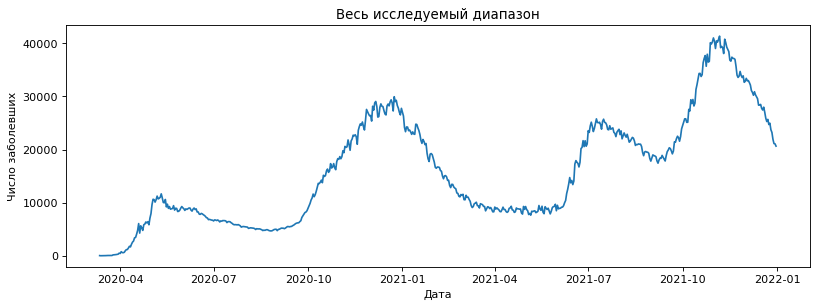

In [849]:
figure(figsize=(12, 4), dpi=80)
plt.plot(df.index,df['Заражений за день'])
plt.xlabel('Дата')
plt.ylabel('Число заболевших')
plt.title('Весь исследуемый диапазон')
plt.show()

Отрежем последние 100 дней от исходного датафрейма. Будем последние 100 дней ипользовать как тест нашего предсказания. <br>
Данное число дней взято таким образом, чтобы пресказать на тесте поведение новой волны - последней волны 2021 года, которая началась в сентябре

In [850]:
x = df.shape[0] - 100
print('Число дней, на которых будем обучать =', x)

Число дней, на которых будем обучать = 560


Обрежем данные на тест и трейн:

In [851]:
dataset = df.values.astype('float32') 
train = df.iloc[:x]
test = df.iloc[x:]

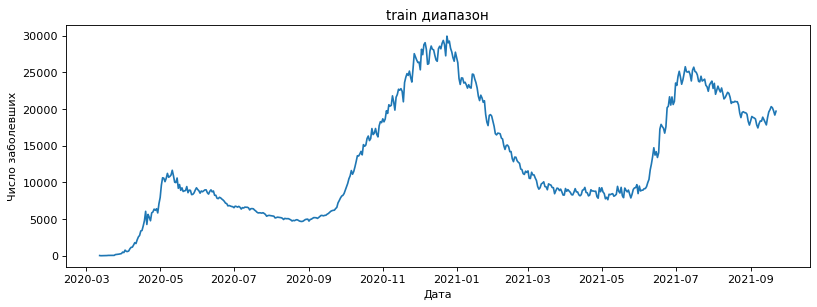

In [852]:
figure(figsize=(12, 4), dpi=80)
plt.plot(train.index, train['Заражений за день'])
plt.xlabel('Дата')
plt.ylabel('Число заболевших')
plt.title('train диапазон')
plt.show()

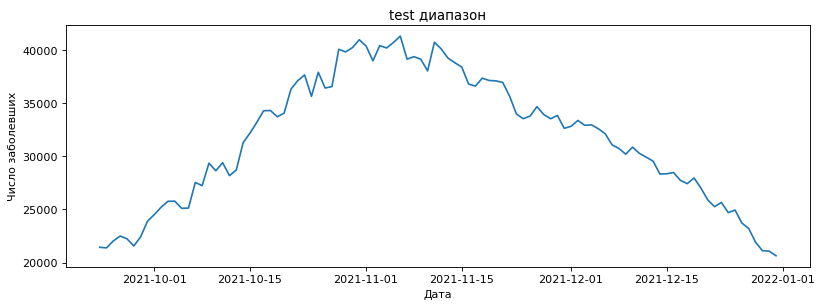

In [853]:
figure(figsize=(12, 4), dpi=80)
plt.plot(test.index, test['Заражений за день'])
plt.xlabel('Дата')
plt.ylabel('Число заболевших')
plt.title('test диапазон')
plt.show()

Теперь сделаем нормализацию данных, которые будут использоваться при обучении и тестировании работы нейронной сети. Воспользуемся для этого MinMaxScaler и сделаем его fit на трейновых данных

In [854]:
scaler = MinMaxScaler()
scaler.fit(train) 

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

Напишем функцию для предподготовки данных для обучения и тестирования работы рекурентной сети.<br>
На вход подаются значения за _seq_size_ дней предыдущих и на выходе сеть предсказывает последующее одно значение. Тем самым архитектура сети является Sequence-to-vector 

In [855]:
seq_size = 20

Благодаря проведенным испытаниям работы сети лучшим гиперпараметром стало число шагов назад для анализа равное 20. <br>
То есть сеть при предсказании последующего значения обладает информацией о последних 20 значениях заболеваемости. На вход LSTM сети будет поступать на каждом шаге именно 20 значений.

In [856]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

In [857]:
trainX, trainY = to_sequences(train_scaled, seq_size)
testX, testY = to_sequences(test_scaled, seq_size)

In [858]:
print("Размер данных для обучения (train): {}".format(trainX.shape))
print("Размер данных для теста (test): {}".format(testX.shape))

Размер данных для обучения (train): (539, 20)
Размер данных для теста (test): (79, 20)


При этом оценивать качество сети мы будем не только как умение с высокой точностью пресказывать 21-ое значение при задании 20 известных значений, но и сам факт пресказания, в котором каждое последующее пресказание имеет накопительную ошибку предыдущих предсказаний.
<br>То есть при тестировании будет использоваться не только test датасет, который мы на прошлом шаге составили, но и датасет который будет составляться сам в процессе пресказания. В таком случае мы по предсказвнным значениям будем предсказывать следующие значения и так далее.

Для подачи данных на обучение надо немного решейпнуть данные, приведя их к виду: trainX.shape[0], число фич, trainX.shape[1].<br>
Число фич - это по сути число различных временных одновременных последовательностей, принимающих участие в предсказании. <br>В нашем случае мы предсказывем поведение временной зависимости заболеваемости от ее же поведения за предыдущие моменты времени, поэтому число фич = 1

In [859]:
n_features = 1

In [860]:
trainX = np.reshape(trainX, (trainX.shape[0], n_features, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], n_features, testX.shape[1]))

In [861]:
print("Финальный размер данных для обучения (train): {}".format(trainX.shape))
print("Финальный размер данных для теста (test): {}".format(testX.shape))

Финальный размер данных для обучения (train): (539, 1, 20)
Финальный размер данных для теста (test): (79, 1, 20)


__Зададим модель нейронной сети:__

LSTM (long short-term memory, дословно (долгая краткосрочная память) — тип рекуррентной нейронной сети, способный обучаться долгосрочным зависимостям.

In [862]:
model = Sequential()
model.add(LSTM(150, activation='relu', return_sequences=True, input_shape=(None, seq_size)))  # Первый слой LSTM
# return_sequences=True так LSTM первого слоя передает данные на второй слой LSTM
model.add(LSTM(64, activation='relu'))  # Второй слой LSTM
model.add(Dense(64))  # Полносвязный слой из 64 нейронов
model.add(Dense(1))  # Выходной слой (одно значение на выходе сети)
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, None, 150)         102600    
                                                                 
 lstm_37 (LSTM)              (None, 64)                55040     
                                                                 
 dense_36 (Dense)            (None, 64)                4160      
                                                                 
 dense_37 (Dense)            (None, 1)                 65        
                                                                 
Total params: 161,865
Trainable params: 161,865
Non-trainable params: 0
_________________________________________________________________


__Обучение сети:__

In [863]:
print('Train...')
history = model.fit(x=trainX,
                    y=trainY,        
                    validation_data=(testX, testY), 
                    epochs=50)

Train...
Epoch 1/50
17/17 [==============================] - 2s 20ms/step - loss: 0.1259 - val_loss: 0.0207
Epoch 2/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0199 - val_loss: 0.0756
Epoch 3/50
17/17 [==============================] - 0s 5ms/step - loss: 0.0118 - val_loss: 0.0442
Epoch 4/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0401
Epoch 5/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0415
Epoch 6/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0544
Epoch 7/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0048 - val_loss: 0.0629
Epoch 8/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0476
Epoch 9/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0313
Epoch 10/50
17/17 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0426
Epoch 11/

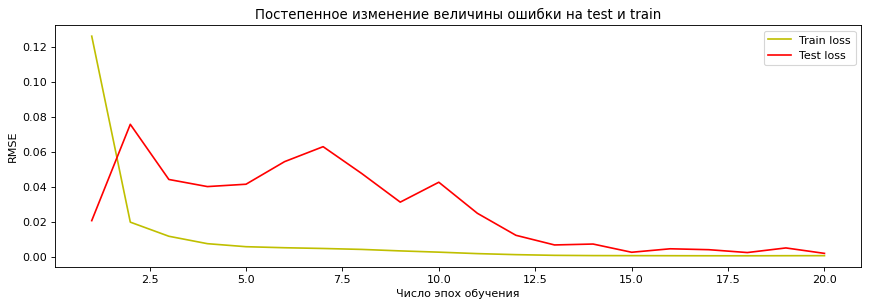

In [864]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
figure(figsize=(13, 4), dpi=80)
plt.plot(epochs[:20], loss[:20], 'y', label='Train loss')
plt.plot(epochs[:20], val_loss[:20], 'r', label='Test loss')
plt.title('Постепенное изменение величины ошибки на test и train')
plt.xlabel('Число эпох обучения')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [865]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


3/3 [==============================] - 0s 1ms/step


Вычисление root mean squared error:

In [866]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 687.06 RMSE
Test Score: 1450.65 RMSE


Подготовка данных к отображению на графиках:

Мы должны сместить прогнозы так, чтобы они совпали по оси x с исходным набором данных.

In [867]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

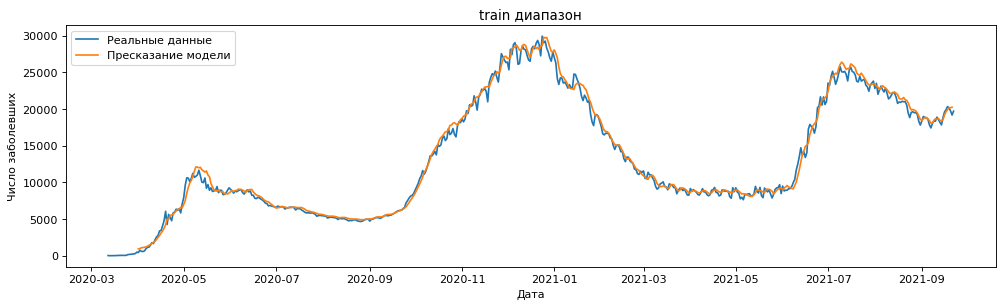

In [868]:
figure(figsize=(15, 4), dpi=80)
plt.plot(train.index, train['Заражений за день'], label='Реальные данные')
plt.plot(train.index, trainPredictPlot[:x], label='Пресказание модели')
plt.xlabel('Дата')
plt.ylabel('Число заболевших')
plt.title('train диапазон')
plt.legend()
plt.show()

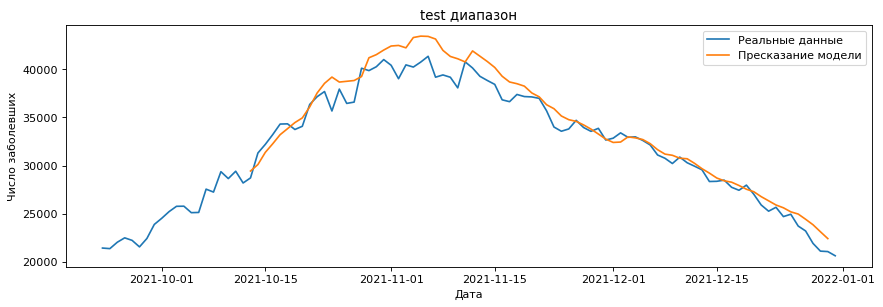

In [869]:
figure(figsize=(13, 4), dpi=80)
plt.plot(test.index, test['Заражений за день'], label='Реальные данные')
plt.xlabel('Дата')
plt.ylabel('Число заболевших')
plt.plot(test.index, testPredictPlot[x:], label='Пресказание модели')
plt.title('test диапазон')
plt.legend()
plt.show()

Сдвиг такой вызван тем, что при тестировании мы начинали предсказыать лишь с 21 дня. Первые 20 дней стали участниками первого пресказания

In [870]:
print(testY.shape)
print(testPredict.shape)

(1, 79)
(79, 1)


In [871]:
mae = mean_absolute_error(testY[0], testPredict[:,0])
print('В среднем прогноз числа заболеваний COVID-19 на 1 ближайший день ошибается на',
      round(mae),'человек')

В среднем прогноз числа заболеваний COVID-19 на 1 ближайший день ошибается на 1116 человек


Обратим внимание на то, что в даннный момент мы лишь оценивали качество текущего прогноза 21-ого значения временного ряда, основываясь на знании поведения 20 предыдущих изестных нам значений. То есть нейронка стремилась делать прогноз на 1 день с высокой степенью точности.

Но в задаче реального прогноза ошибка прогноза на n-ый день будет включать в себя ошибки прогноза на 1, 2, 3 и до n-1 дни. То есть с ростом времени все менее и менее точным будет наш прогноз. Убедимся в этом:

In [872]:
current_batch = train_scaled[-seq_size:]  # Зададим текущий батч для обучения
current_batch = current_batch.reshape(1, n_features, seq_size)  # Решейпним его в нужные для модели размеры

Будем предсказывать на 30 дней:

In [873]:
future = 30  # дней

In [874]:
prediction = []  # Пустой лист для добавления предсказаний

# Тут возникло много мороки с решейпами, но задача оказалось решаемой :)

for i in range(future):
    #print(model.predict(current_batch))
    current_pred = model.predict(current_batch)[0]  # Текущий для данного батча предикт
    prediction.append(current_pred)
    current_batch = np.append(current_batch[0,0,1:], current_pred)  
    # Переделывем батч, отбрасывая начальный элемент и добавляя в конце последний полученный предикт
    current_batch = current_batch.reshape(1, n_features, seq_size)  # Опять решейпим

1/1 [==============================] - 0s 16ms/step


In [875]:
prediction = np.asarray(prediction, dtype=np.float32)
rescaled_prediction = scaler.inverse_transform(prediction) # Переводим в исходный масштаб предикты

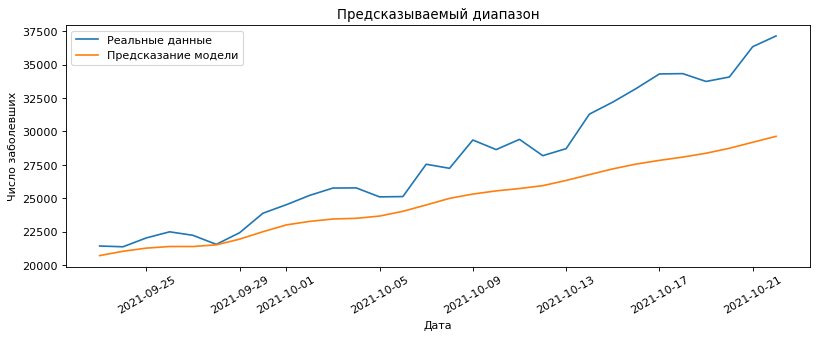

In [876]:
figure(figsize=(12, 4), dpi=80)
plt.plot(test.index[:rescaled_prediction.shape[0]],
         test['Заражений за день'][:rescaled_prediction.shape[0]],
         label='Реальные данные')
plt.plot(test.index[:rescaled_prediction.shape[0]],
         rescaled_prediction[:,0],
         label ='Предсказание модели')
plt.xlabel('Дата')
plt.ylabel('Число заболевших')
plt.title('Предсказываемый диапазон')
plt.legend()
plt.xticks(rotation = 30)
plt.show()

In [877]:
current_pred = model.predict(current_batch)[0]

1/1 [==============================] - 0s 17ms/step


In [878]:
data_y = np.empty_like(df.values[:,0], dtype=np.float64)
data_y[:] = np.nan
data_y.shape

(660,)

Дата, с которой у нас начинается предсказание:

In [879]:
df.index[x]

Timestamp('2021-09-23 00:00:00')

Итоговый результат предсказания на 30 дней с 23 сентября 2021:

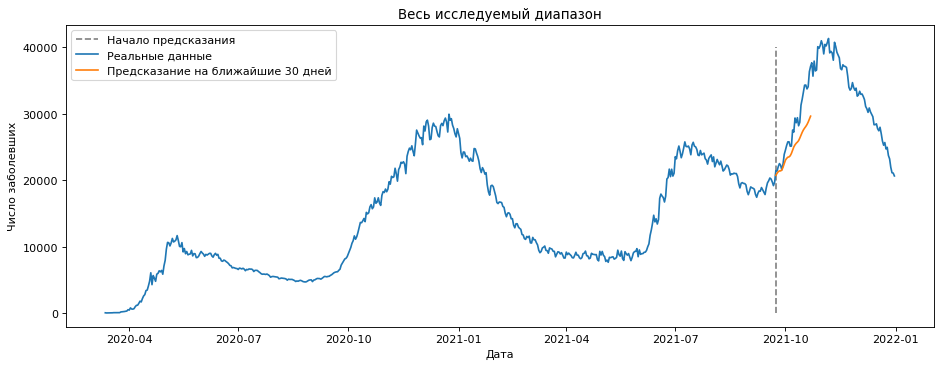

In [880]:
data_y[x:rescaled_prediction.shape[0]+x] = rescaled_prediction[:,0]
figure(figsize=(14, 5), dpi=80)
plt.plot([df.index[x],df.index[x]], [0,40000],
         linestyle='dashed', color='gray',
         label ='Начало предсказания')
plt.plot(df.index,df['Заражений за день'],
         label ='Реальные данные')
plt.plot(df.index, data_y,
         label ='Предсказание на ближайшие 30 дней')
plt.xlabel('Дата')
plt.ylabel('Число заболевших')
plt.title('Весь исследуемый диапазон')
plt.legend()
plt.show()

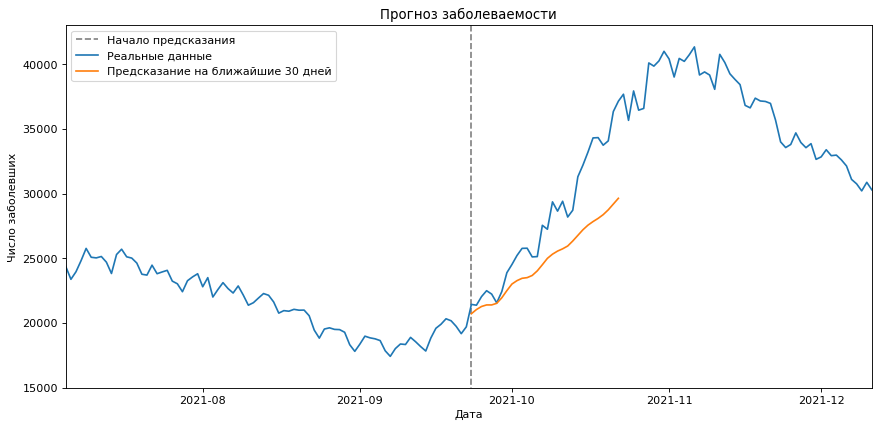

In [881]:
figure(figsize=(13, 6), dpi=80)
plt.plot([df.index[x],df.index[x]], [0,45000],
         linestyle='dashed', color='gray',
         label ='Начало предсказания')
plt.plot(df.index,df['Заражений за день'],
         label ='Реальные данные')
plt.plot(df.index, data_y,
         label ='Предсказание на ближайшие 30 дней')
plt.xlabel('Дата')
plt.ylabel('Число заболевших')
plt.title('Прогноз заболеваемости')
plt.legend()
plt.xlim([df.index[x-80], df.index[x+79]])
plt.ylim([15000, 43000])
plt.show()

Тем самым мы на самом начале новой волны предсказали значительный рост случаев заражения в течение ближайшего месяца. Сеть с задачей предсказания справилась успешно.

Если же предсказывать, начиная с 13 октября 2021 года (в период разгара новой волны), и запросить модель выдать прогноз на ближайшие 70 дней, то модель очень точно предскажет конец волны и начало скорого спада заболеваемости

<p align="center"> <img align="center" src="./prediction.png" alt="kolesnokov__dima" height="825" width="1025" /> </center>  